In [ ]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/lasseufpa/ml4comm-icc21.git
    except:
      print("ml4comm-icc21 is already in the contents")
    !pip install -r /content/ml4comm-icc21/requirements.txt  &>/dev/null
    sys.path.append(os.path.abspath('/content/ml4comm-icc21'))

In [1]:
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from commpy.channels import SISOFlatChannel

sys.path.append(os.path.abspath('ml4comm'))
from ml4comm.qam_awgn import generate_symbols
import my_utils

np.random.seed(42) # Important

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


In [4]:
def train_decision_tree():
    parameters = {
        'max_depth': [100, 50, 10]
    }

    DSTC = DecisionTreeClassifier()
    
    train_sizes = [200, 500]
    ds = my_utils.Dataset(channel_type='crazy')
    
    for size in train_sizes:
        X_train, y_train = ds.get_train_dataset(n_samples=size)
        best_clf = my_utils.grid_search(DSTC, X_train, y_train, parameters, name='Decision Tree')
        my_utils.plots(best_clf, X_train, y_train, ds.M)
        

------------ Decision Tree ---------------
TRAIN SIZE: 200
ranks: [1 2 3]
rank 1: {'max_depth': 100} - score: -0.185
rank 2: {'max_depth': 50} - score: -0.19
rank 3: {'max_depth': 10} - score: -0.195


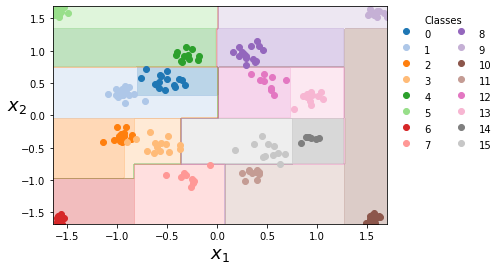

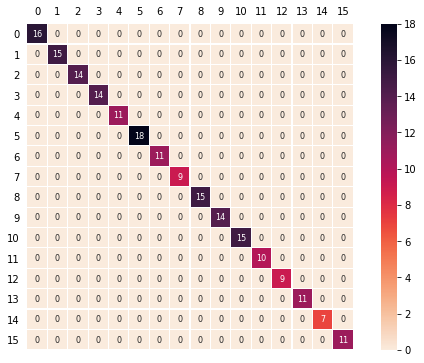

------------ Decision Tree ---------------
TRAIN SIZE: 500
ranks: [1 1 3]
rank 1: {'max_depth': 100} - score: -0.28200000000000003
rank 1: {'max_depth': 100} - score: -0.28200000000000003
rank 3: {'max_depth': 10} - score: -0.346


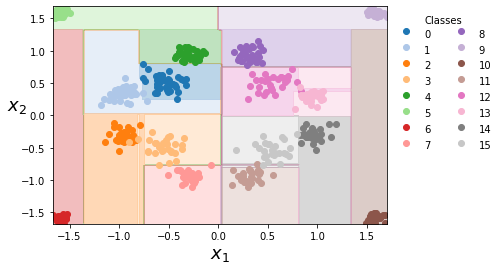

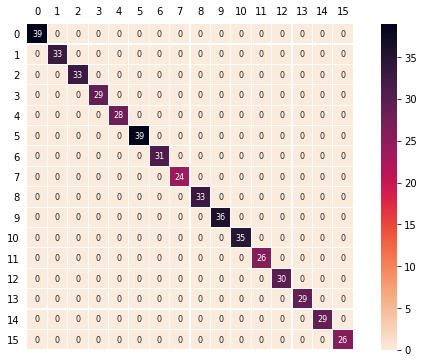

In [5]:
def main():
    train_decision_tree()

if __name__ == '__main__':
    main()